# Ball Detection using the SweatyNet Model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Import statements

In [0]:
from __future__ import print_function, division
%matplotlib inline
import torch as t
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms, utils
import torchvision.transforms.functional as f
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
import time
import os
from torch.utils.data.dataset import Dataset
import pandas as pd
import skimage
from skimage import io, transform, img_as_ubyte
import random
from PIL import Image
import cv2
import math

t.set_default_tensor_type('torch.cuda.FloatTensor')

# SweatyNet

##*SweatyNet* - 1 Model

In [0]:
# SweatyNet-1 Model 

class SweatyModel1(nn.Module):
    def __init__(self):
        super(SweatyModel1,self).__init__()
          
        # batch x 640 x 512
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=3//2),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        # batch x 320 x 256
        self.pooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=3//2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        
            nn.Conv2d(16, 16, 3, padding=3//2),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        #concat1 = (maxpool1 + layer2) -> 8 + 16 = 24
        
        # batch x 160 x 128
        self.pooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = nn.Sequential(
            nn.Conv2d(24, 32, 3, padding=3//2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        
            nn.Conv2d(32, 32, 3, padding=3//2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        #concat2 = (maxpool2 + layer3) -> 24 + 32 = 56
        
        # batch x 80 x 64
        self.pooling3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer4 = nn.Sequential(
            nn.Conv2d(56, 64, 3, padding=3//2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=3//2),  
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=3//2),  
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #concat3 = (maxpool3 + layer4) -> 56 + 64 = 120
                
        # batch x 40 x 32
        self.pooling4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = nn.Sequential(
            nn.Conv2d(120, 128, 3, padding=3//2),  
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=3//2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=3//2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, 3, padding=3//2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # batch x 80 x 64
        #concat4 = (concat3 + upsample1) -> 120 + 64 = 184
        self.layer6 = nn.Sequential(
            nn.Conv2d(184, 64, 1, padding=1//2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, 3, padding=3//2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, padding=3//2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        # batch x 160 x 128
        #concat5 = (concat2 + upsample2) -> 56 + 32 = 88
        self.layer7 = nn.Sequential(
            nn.Conv2d(88, 16, 1, padding=1//2),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3, padding=3//2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 1, 3, padding=3//2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )        
        
    def forward(self, x):
            
        # batch x 640 x 512
        layer_out1 = self.layer1(x)
        
        # batch x 320 x 256
        pool_out1 = self.pooling1(layer_out1)
        layer_out2 = self.layer2(pool_out1)
        concat_out1 = t.cat((pool_out1, layer_out2), dim=1)
        
        # batch x 160 x 128
        pool_out2 = self.pooling2(concat_out1)
        layer_out3 = self.layer3(pool_out2)
        concat_out2 = t.cat((pool_out2, layer_out3), dim=1)
        
        # batch x 80 x 64
        pool_out3 = self.pooling3(concat_out2)
        layer_out4 = self.layer4(pool_out3)
        concat_out3 = t.cat((pool_out3, layer_out4), dim=1)
        
        # batch x 40 x 32
        pool_out4 = self.pooling4(concat_out3)
        layer_out5 = self.layer5(pool_out4)
        upsample_out1 = func.interpolate(layer_out5, scale_factor=2, mode='bilinear', align_corners=True)
        
        # batch x 80 x 64
        concat_out4 = t.cat((concat_out3, upsample_out1), dim=1)
        layer_out6 = self.layer6(concat_out4)
        upsample_out2 = func.interpolate(layer_out6, scale_factor=2, mode='bilinear', align_corners=True)
        
        # batch x 160 x 128
        concat_out5 = t.cat((concat_out2, upsample_out2), dim=1)
        out = self.layer7(concat_out5)
              
        return out

##  SweatyNet -2 Model

In [0]:
# SweatyNet-2 Model 

class SweatyModel2(nn.Module):
    def __init__(self):
        super(SweatyModel2,self).__init__()
          
        # batch x 640 x 512
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=3//2),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        # batch x 320 x 256
        self.pooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=3//2),
            nn.BatchNorm2d(16),
            nn.ReLU()
        
        )
        #concat1 = (maxpool1 + layer2) -> 8 + 16 = 24
        
        # batch x 160 x 128
        self.pooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = nn.Sequential(
            nn.Conv2d(24, 32, 3, padding=3//2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        
        )
        #concat2 = (maxpool2 + layer3) -> 24 + 32 = 56
        
        # batch x 80 x 64
        self.pooling3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer4 = nn.Sequential(
            nn.Conv2d(56, 64, 3, padding=3//2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=3//2),  
            nn.BatchNorm2d(64),
            nn.ReLU()

        )
        #concat3 = (maxpool3 + layer4) -> 56 + 64 = 120
                
        # batch x 40 x 32
        self.pooling4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = nn.Sequential(
            nn.Conv2d(120, 128, 3, padding=3//2),  
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=3//2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, 3, padding=3//2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # batch x 80 x 64
        #concat4 = (concat3 + upsample1) -> 120 + 64 = 184
        self.layer6 = nn.Sequential(
            nn.Conv2d(184, 64, 1, padding=1//2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, 3, padding=3//2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, padding=3//2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        # batch x 160 x 128
        #concat5 = (concat2 + upsample2) -> 56 + 32 = 88
        self.layer7 = nn.Sequential(
            nn.Conv2d(88, 16, 1, padding=1//2),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3, padding=3//2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 1, 3, padding=3//2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )        
        
    def forward(self, x):
            
        # batch x 640 x 512
        layer_out1 = self.layer1(x)
        
        # batch x 320 x 256
        pool_out1 = self.pooling1(layer_out1)
        layer_out2 = self.layer2(pool_out1)
        concat_out1 = t.cat((pool_out1, layer_out2), dim=1)
        
        # batch x 160 x 128
        pool_out2 = self.pooling2(concat_out1)
        layer_out3 = self.layer3(pool_out2)
        concat_out2 = t.cat((pool_out2, layer_out3), dim=1)
        
        # batch x 80 x 64
        pool_out3 = self.pooling3(concat_out2)
        layer_out4 = self.layer4(pool_out3)
        concat_out3 = t.cat((pool_out3, layer_out4), dim=1)
        
        # batch x 40 x 32
        pool_out4 = self.pooling4(concat_out3)
        layer_out5 = self.layer5(pool_out4)
        upsample_out1 = func.interpolate(layer_out5, scale_factor=2, mode='bilinear', align_corners=True)
        
        # batch x 80 x 64
        concat_out4 = t.cat((concat_out3, upsample_out1), dim=1)
        layer_out6 = self.layer6(concat_out4)
        upsample_out2 = func.interpolate(layer_out6, scale_factor=2, mode='bilinear', align_corners=True)
        
        # batch x 160 x 128
        concat_out5 = t.cat((concat_out2, upsample_out2), dim=1)
        out = self.layer7(concat_out5)
              
        return out

## SweatyNet -3 Model

In [0]:
# SweatyNet-3 Model 

class SweatyModel3(nn.Module):
    def __init__(self):
        super(SweatyModel3,self).__init__()
          
        # batch x 640 x 512
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=3//2),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        # batch x 320 x 256
        self.pooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 8, 1, padding=1//2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        
            nn.Conv2d(8, 16, 3, padding=3//2),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        #concat1 = (maxpool1 + layer2) -> 8 + 16 = 24
        
        # batch x 160 x 128
        self.pooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = nn.Sequential(
            nn.Conv2d(24, 16, 1, padding=1//2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        
            nn.Conv2d(16, 32, 3, padding=3//2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        #concat2 = (maxpool2 + layer3) -> 24 + 32 = 56
        
        # batch x 80 x 64
        self.pooling3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer4 = nn.Sequential(
            nn.Conv2d(56, 32, 1, padding=1//2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, padding=3//2),  
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, 1, padding=1//2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, padding=3//2),  
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #concat3 = (maxpool3 + layer4) -> 56 + 64 = 120
                
        # batch x 40 x 32
        self.pooling4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = nn.Sequential(
            nn.Conv2d(120, 64, 1, padding=1//2),  
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, padding=3//2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, 1, padding=1//2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, padding=3//2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, 3, padding=3//2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # batch x 80 x 64
        #concat4 = (concat3 + upsample1) -> 120 + 64 = 184
        self.layer6 = nn.Sequential(
            nn.Conv2d(184, 64, 1, padding=1//2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, 3, padding=3//2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, padding=3//2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        # batch x 160 x 128
        #concat5 = (concat2 + upsample2) -> 56 + 32 = 88
        self.layer7 = nn.Sequential(
            nn.Conv2d(88, 16, 1, padding=1//2),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3, padding=3//2),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 1, 3, padding=3//2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )        
        
    def forward(self, x):
            
        # batch x 640 x 512
        layer_out1 = self.layer1(x)
        
        # batch x 320 x 256
        pool_out1 = self.pooling1(layer_out1)
        layer_out2 = self.layer2(pool_out1)
        concat_out1 = t.cat((pool_out1, layer_out2), dim=1)
        
        # batch x 160 x 128
        pool_out2 = self.pooling2(concat_out1)
        layer_out3 = self.layer3(pool_out2)
        concat_out2 = t.cat((pool_out2, layer_out3), dim=1)
        
        # batch x 80 x 64
        pool_out3 = self.pooling3(concat_out2)
        layer_out4 = self.layer4(pool_out3)
        concat_out3 = t.cat((pool_out3, layer_out4), dim=1)
        
        # batch x 40 x 32
        pool_out4 = self.pooling4(concat_out3)
        layer_out5 = self.layer5(pool_out4)
        upsample_out1 = func.interpolate(layer_out5, scale_factor=2, mode='bilinear', align_corners=True)
        
        # batch x 80 x 64
        concat_out4 = t.cat((concat_out3, upsample_out1), dim=1)
        layer_out6 = self.layer6(concat_out4)
        upsample_out2 = func.interpolate(layer_out6, scale_factor=2, mode='bilinear', align_corners=True)
        
        # batch x 160 x 128
        concat_out5 = t.cat((concat_out2, upsample_out2), dim=1)
        out = self.layer7(concat_out5)
              
        return out

##Custom Dataset Loader

In [0]:
# Custom ToTensor

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        
        # swap color axis 
        # numpy image: H x W x C
        # torch image: C X H X W
        
        image = image.permute(2, 0, 1)
        image = image.ToTensor()
        
        return {'image': image,
                'labels': labels}

In [0]:
# Custom Rescale

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, height, width):
        self.new_h = height
        self.new_w = width

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        h, w = image.shape[:2]

        new_h, new_w = int(self.new_h), int(self.new_w)
        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'labels': labels}

In [0]:

# Creation of Custom Dataset and transforms

class SoccerBallDataset(Dataset):
    
    def __init__(self, root_dir, annotation_path, transformation=None):
       
        self.target = []
        self.root_dir = root_dir
        self.annotation_path = annotation_path
        self.transformation = transformation
        self.annotations_frame = pd.read_csv(self.annotation_path)
        
        for index, rows in self.annotations_frame.iterrows():
          img_name, width, height, x1, y1, x2, y2, c_x, c_y, w, h = rows
          
          x1 = x1 / 4
          x2 = x2 / 4
          y1 = y1 / 4
          y2 = y2 / 4
          x = (x1 + x2) / 2
          y = (y1 + y2) / 2

          center =(x,y)
          var = 6
          
          matrix = np.zeros((128,160))
          
          if (x>0 and y>0):
            for i in range(int(x1), int(x2)):
              for j in range(int(y1), int(y2)):
                matrix[j,i] = 100*multivariate_normal.pdf([i,j], center, [var,var])
       

          self.target.append(matrix)
          
    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.annotations_frame.iloc[idx, 0])
        image = io.imread(img_name)
        
        sample = {'image': t.from_numpy(image), 'labels': t.from_numpy(self.target[idx]).unsqueeze(-1)}
        
        if self.transformation:
            sample = self.transformation(sample)

        return sample

## Evaluation

In [0]:
class Sweaty_ModelEvaluator:

    def __init__(self, model_path, val_images_path, test_images_path, num_epochs):
      self.model_path = model_path
      self.val_images_path = val_images_path
      self.test_images_path = test_images_path
      self.num_epochs = num_epochs
      
    # Creating and loading the train and test dataset
    def data_loading(self, root_dir, annotation_path, batch_size, shuffle):
      transformed_dataset = SoccerBallDataset(root_dir, 
                                              annotation_path, 
                                              transformation=transforms.Compose([
                                                  Rescale(512, 640)
                                              ]))

      dataset_loader = t.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,
                                               shuffle=shuffle, num_workers=4, drop_last=True)

      return dataset_loader
    
    
    # Training the model
    def train_model(self, model, train_loader):
        epoch_loss = []
        train_loss_list = []
        train_output = []
        predicted = 0.0
        train_label_size = 0

        for epoch in range(self.num_epochs):
            running_loss = 0.0
            running_corrects = 0

            for i, batch in enumerate(train_loader):
                batch_images = batch['image'].permute(0,3,1,2)
                batch_labels = batch['labels'].permute(0,3,1,2)

                batch_images = batch_images/255

                if t.cuda.is_available():
                  batch_images = batch_images.cuda().float()
                  batch_labels = batch_labels.cuda().float()
                else:
                  batch_images = batch_images
                  batch_labels = batch_labels

                # Clearing the gradients 
                sweaty_optimizer.zero_grad()

                # Passing the image dataset to the Sweaty model
                output = model(batch_images)
                train_output.append(output)

                # Calculating the Loss(MSE)
                train_loss = sweaty_criterion(output, batch_labels)

                # Getting the gradients 
                train_loss.backward()

                # Updating the parameters
                sweaty_optimizer.step()

                train_loss_list.append(train_loss)
                running_loss += train_loss.data

                train_label_size += batch_labels.size(0) 

            # Calculate train loss and accuracy  
            epoch_loss = running_loss / train_label_size
            print('Epoch {}/{}\t - Loss: {:.8f}'.format(epoch+1, self.num_epochs, epoch_loss.data))
            
            if epoch % 5 == 0:
              t.save(sweaty_model.state_dict(), self.model_path+'sweatynet1_trained_epoch_'+str(epoch)+'.pkl')

        return model, train_loss_list, train_output
    
    
    # Validating the model
    def validation_model(self, model, val_loader):
        epoch_loss = []
        val_output = []
        val_loss_list = []

        # Iterate through validation dataset
        for i, batch in enumerate(val_loader):
            batch_images = batch['image'].permute(0,3,1,2)
            batch_labels = batch['labels'].permute(0,3,1,2)

            batch_images = batch_images/255

            if t.cuda.is_available():
              batch_images = batch_images.cuda().float()
              batch_labels = batch_labels.cuda().float()
            else:
              batch_images = batch_images
              batch_labels = batch_labels

            # Output from the model
            voutput = model(batch_images)
            val_output.append(voutput)

            # Finding the validation loss
            val_loss = sweaty_criterion(voutput, batch_labels)

            val_loss_list.append(val_loss)

            target_img = self.val_images_path+'sweaty1_val_target'+str(i)+'.png'
            output_img = self.val_images_path+'sweaty1_val_output'+str(i)+'.png'

            if i % 5 == 0:      
              for j in range(1):
                print('#',i)
                self.visualize_output((batch_labels[j].reshape(1,128,160)).cpu().detach().numpy(), 'Target')
                #plt.imshow((batch_images[j].reshape(3,512,640)).cpu().detach().numpy())
                self.visualize_output((voutput[j]).cpu().detach().numpy(), 'Output')
                #torchvision.utils.save_image(batch_labels[j], target_img)
                #torchvision.utils.save_image(voutput[j], output_img)
                
        return val_output, val_loss_list    

    
    # Testing the model
    def test_model(self, model, test_loader):
        epoch_loss = []
        test_output = []
        test_loss_list = []

        # Iterate through test dataset
        for i, batch in enumerate(test_loader):
            batch_images = batch['image'].permute(0,3,1,2)
            batch_labels = batch['labels'].permute(0,3,1,2)

            batch_images = batch_images/255

            if t.cuda.is_available():
              batch_images = batch_images.cuda().float()
              batch_labels = batch_labels.cuda().float()
            else:
              batch_images = batch_images
              batch_labels = batch_labels

            # Output from the model
            outputs = model(batch_images)
            test_output.append(outputs)

            # Finding the test loss
            test_loss = sweaty_criterion(outputs, batch_labels)

            test_loss_list.append(test_loss)

            target_img = self.test_images_path+'sweaty1_test_target_'+str(i)+'.png'
            output_img = self.test_images_path+'sweaty1_test_output_'+str(i)+'.png'
            
            if 1:      
              for j in range(1):
                print('\n#Frame',i)
                torchvision.utils.save_image(batch_labels[j], target_img)
                torchvision.utils.save_image(outputs[j], output_img)
                if i % 5 == 0:
                  self.visualize_output((batch_labels[j].reshape(1,128,160)).cpu().detach().numpy(), 'Target')
                  #plt.imshow((batch_images[j].reshape(3,512,640)).cpu().detach().numpy())
                  self.visualize_output((outputs[j]).cpu().detach().numpy(), 'Output')
                
                j+=1

        return test_output, test_loss_list 

    # Plotting the loss
    def plot_loss(self, loss, save_dir):

        plt.clf()

        iterations = range(1, len(loss)+1)
        plt.title('Loss')
        plt.plot(iterations, loss, color = 'b')
        plt.xlabel('Number of iterations')
        plt.ylabel('Loss')

        plt.savefig(save_dir)
        plt.clf()  

    # Visualizing the output      
    def visualize_output(self, out, title='None'):

        plt.figure(figsize=(5,5))
        for i in range(1):
            plt.subplot(6,6,i+1)
            #plt.xticks([])
            #plt.yticks([])
            plt.axes()
            plt.grid(False)
            plt.Text('Heading')
            plt.title(title)
            plt.imshow(out[i], cmap = 'gray')
            #plt.colorbar()
        plt.show()        

In [0]:
target_coordinate_list=[]

## Post Processing

In [0]:
class PostProcessing:

    def __init__(self):
        self.list_maximal_values_batches = []
      
    # Creating the test coordinates list of the ball 
    def get_coordinates(self, annotation_path):

        target_coordinates = []
        annotations_frame = pd.read_csv(annotation_path)

        for index, rows in annotations_frame.iterrows():
          _, _, _, x1, y1, x2, y2, _, _, _, _ = rows

          x1 = x1 / 4
          x2 = x2 / 4
          y1 = y1 / 4
          y2 = y2 / 4
          x = (x1 + x2) / 2
          y = (y1 + y2) / 2
          center = (x,y)
          target_coordinates.append(center)

        return target_coordinates
            
    def erosion(self, output_list):
        erosion_list = []
        #img = cv2.imread('j.png',0)
        kernel = np.ones((4,4),np.uint8)
        
        for i in range(0, len(output_list)):
          out = (output_list[i].reshape(1,128,160)).cpu().detach().numpy()
          
          erosion_output = cv2.erode(out, kernel, iterations = 1)
          erosion_list.append(erosion_output)
          
        return erosion_list
        #return output_list
      
    
    def findmaximal(self, test_output_matrix_image, target_center_coordinates):
      
      z=test_output_matrix_image.permute(1,2,0)
      z=test_output_matrix_image
      z.to(dtype=t.float32)
      list_with_more_contours=[]
      internal_list_distance=[]

      center_coord_targ=target_center_coordinates
      number=np.count_nonzero(z.cpu().detach().numpy())
      if(number>0):

        prob_map=z.cpu().detach().numpy()
        prob_map = np.squeeze(prob_map)
        maximum_value=np.amax(prob_map)
        thresh=0.7*maximum_value
        bin_map = prob_map > thresh
        bin_img = img_as_ubyte(bin_map)
        _, cnts ,_= cv2.findContours(bin_img.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        s=0
        r=0
        cx=0.0
        cy=0.0
        for cont in cnts:
          M = cv2.moments(cont)
          if((M['m00']!=0)): 
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00']) 
          else:
            continue


          list_with_more_contours.append((cx,cy))
        
        if(len(list_with_more_contours)>1):
          for k in range(0,len(list_with_more_contours)):
            dist=self.calculateDistance(list_with_more_contours[k][0],list_with_more_contours[k][1],target_center_coordinates[0],target_center_coordinates[1])
            internal_list_distance.append(dist)

          min_index=np.argmin(internal_list_distance)

          min_value=list_with_more_contours[min_index]
          self.list_maximal_values_batches.append(tuple(min_value))
          list_with_more_contours=[]
        else:
          if(len(list_with_more_contours)>0):  
            self.list_maximal_values_batches.append(list_with_more_contours[0])
            list_with_more_contours=[] 
          else:
            self.list_maximal_values_batches.append((0,0))
            

      else:
        self.list_maximal_values_batches.append((0,0))
        
      length_batch=len(self.list_maximal_values_batches)
      return self.list_maximal_values_batches[length_batch-1]


    def calculateDistance(self, x1,y1,x2,y2):
      dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
      return dist  

    def calculate_metrics(self, target_list,output_list):
      error_threshold=10
      true_positive=0
      false_positive=0
      true_negative=0
      false_negative=0
      
      for i in range(0,len(target_list)):
        
        
        if(target_list[i]==(0,0)):
          if output_list[i]!=(0,0):
            false_positive+=1
          else:
            true_negative+=1
        else:
          if (output_list[i]!=(0,0)):
            
            distance = self.calculateDistance(target_list[i][0],target_list[i][1],output_list[i][0],output_list[i][1])
            if (distance < error_threshold):
              true_positive+=1
            else:
              false_negative+=1
          else:
            false_negative+=1

      list_metrics=[true_positive,true_negative,false_positive,false_negative]    
      return list_metrics    

    def calculating_metrics(self, metrics_list):
      true_positive =  metrics_list[0]
      true_negative  = metrics_list[1]
      false_positive = metrics_list[2]
      false_negative = metrics_list[3]
            
      Precision=(true_positive)/(false_positive+true_positive)
      Recall=(true_positive/(true_positive+false_negative))
      IOU=(true_positive/(true_positive+false_positive+false_negative))
      FDR=(false_positive/(false_positive+true_positive))
      Accuracy=(true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)
      
      list_calculated_metrics=[Precision*100, Recall*100, FDR*100, IOU*100, Accuracy*100]
      
      return list_calculated_metrics


    def find_metrics(self, out_list, annotation_path):
      output_list=[]
      metrics_list=[]
      out_erosion_list=[]
      
      target_coordinates = self.get_coordinates(annotation_path)
      out_erosion_list = self.erosion(out_list)
      
      
      
      for i in range(0, len(out_erosion_list)):
        output_list.append(self.findmaximal(t.from_numpy(out_erosion_list[i]), target_coordinates[i]))
        #output_list.append(self.findmaximal(out_erosion_list[i].squeeze(0), target_coordinates[i]))
        

      
      metrics_list = self.calculate_metrics(target_coordinates,output_list)  
      
      PostMetrics = self.calculating_metrics(metrics_list)
      print("Precision: {:.1f} - Recall: {:.1f} - FDR: {:.1f} - IOU: {:.1f} - Accuracy: {:.1f}"
            .format(PostMetrics[0], PostMetrics[1], PostMetrics[2], PostMetrics[3], PostMetrics[4]))


## Initialization

In [0]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 100
batch_size = 1
drop_last = True
beta1 = 0.5

sweaty_model_version = 1

# Paths
source_path = 'gdrive/My Drive/'
model_path = source_path+'SoccerDatasetTrain/sweaty1/'
val_images_path = model_path+'val/'
test_images_path = model_path+'test/'

train_root_dir= source_path+'Data/lab3/'
train_anno_path = source_path+'Data/train_lab3.csv'

val_root_dir= source_path+'Data/test/'
val_anno_path = source_path+'Data/test.csv'

test_root_dir= source_path+'Data/final_sequence_test/'
test_anno_path = source_path+'Data/final_sequence.csv'


sweaty_evaluator = Sweaty_ModelEvaluator(model_path, val_images_path, test_images_path, num_epochs)

# Loading the dataset
train_loader = sweaty_evaluator.data_loading(train_root_dir, train_anno_path, batch_size, shuffle=True)
val_loader = sweaty_evaluator.data_loading(val_root_dir, val_anno_path, batch_size, shuffle=False)
test_loader = sweaty_evaluator.data_loading(test_root_dir, test_anno_path, batch_size, shuffle=False)

# SweatyNet model object creation
if sweaty_model_version == 1:
  sweaty_model = SweatyModel1().cuda().float()
elif sweaty_model_version == 2:
  sweaty_model = SweatyModel2().cuda().float()
else:
  sweaty_model = SweatyModel3().cuda().float()
  
# MSE Loss function
sweaty_criterion = nn.MSELoss()

# Adam Optimitzer function
sweaty_optimizer = t.optim.Adam(sweaty_model.parameters(), lr = learning_rate, betas = (beta1, 0.999))

In [0]:
# Training the model
trained_model, train_loss_list, train_output = sweaty_evaluator.train_model(sweaty_model, train_loader)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# 0


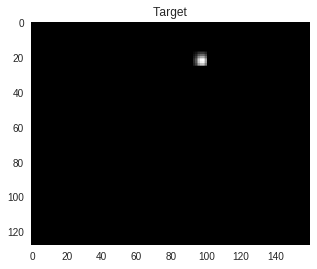

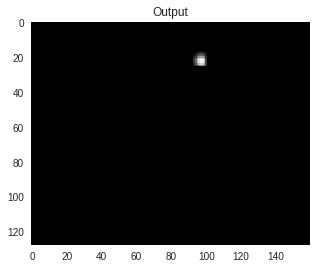

# 5


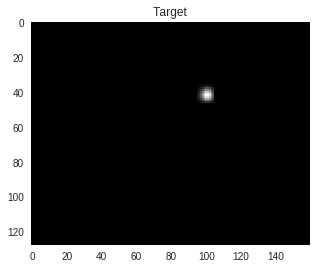

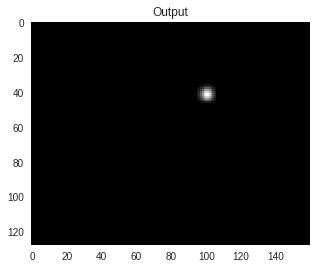

# 10


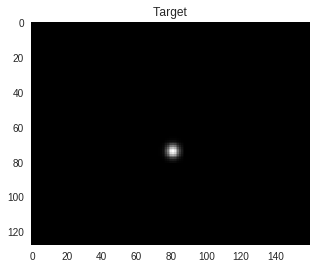

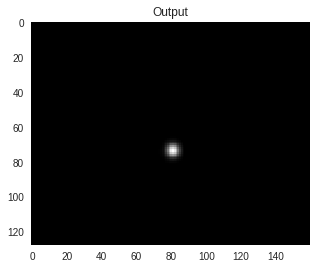

# 15


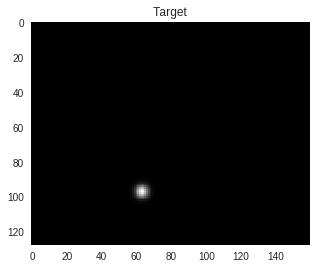

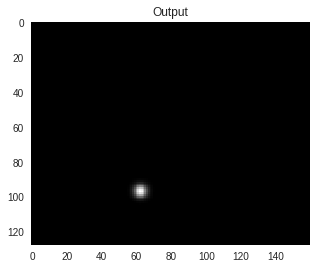

In [0]:
# Validating the model
val_output, val_loss_list = sweaty_evaluator.validation_model(trained_model, val_loader)
np.save('gdrive/My Drive/Dataset/sweaty_val_out_final_project_1', val_output)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



#Frame 0


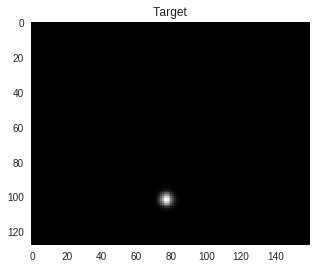

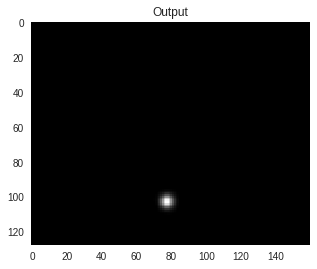


#Frame 1

#Frame 2

#Frame 3

#Frame 4

#Frame 5


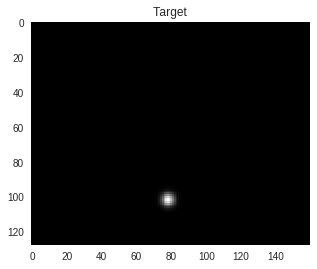

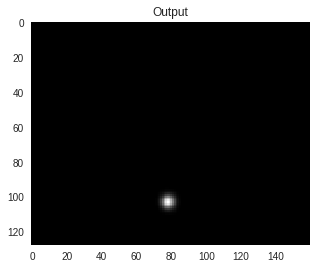


#Frame 6

#Frame 7

#Frame 8

#Frame 9

#Frame 10


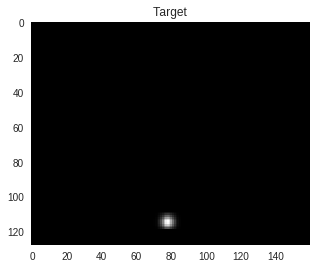

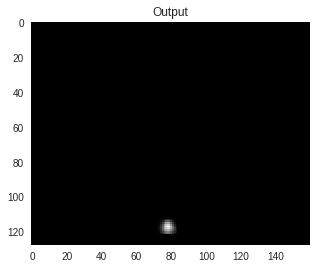


#Frame 11

#Frame 12

#Frame 13

#Frame 14

#Frame 15


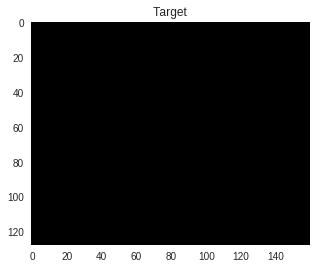

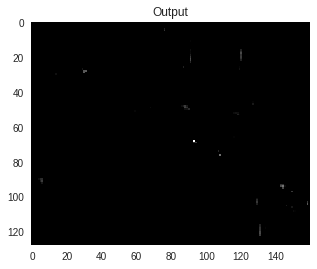


#Frame 16

#Frame 17

#Frame 18

#Frame 19

#Frame 20


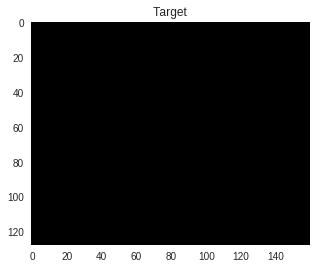

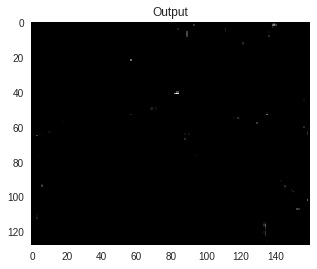


#Frame 21

#Frame 22

#Frame 23

#Frame 24

#Frame 25


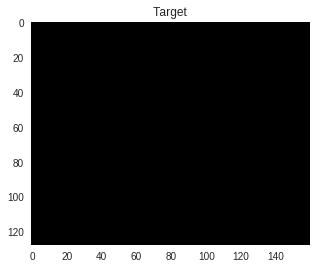

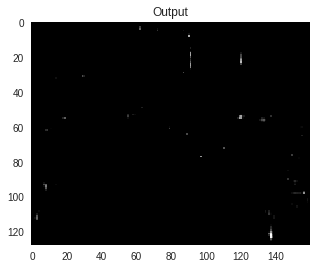


#Frame 26

#Frame 27

#Frame 28

#Frame 29

#Frame 30


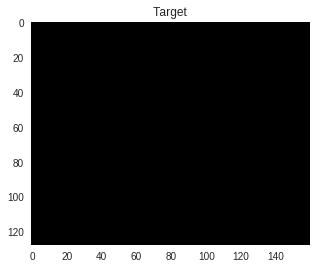

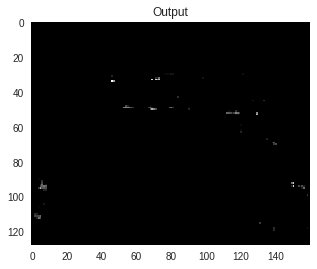


#Frame 31

#Frame 32

#Frame 33

#Frame 34

#Frame 35


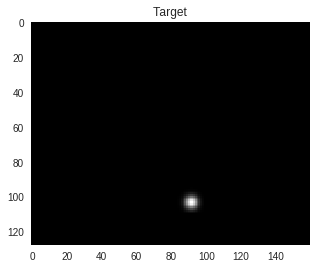

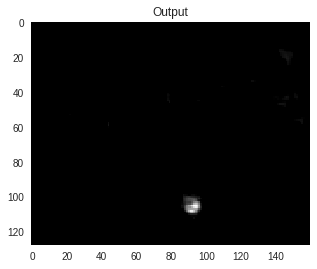


#Frame 36

#Frame 37

#Frame 38

#Frame 39

#Frame 40


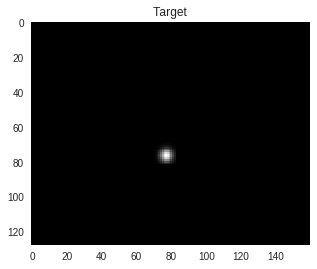

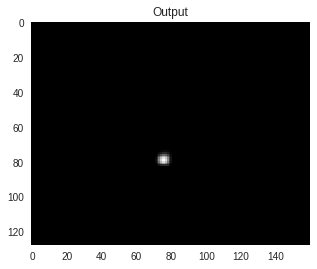


#Frame 41

#Frame 42

#Frame 43

#Frame 44

#Frame 45


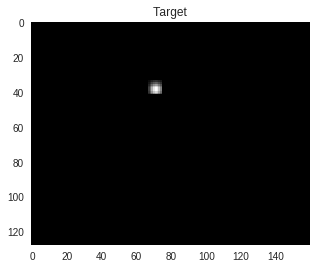

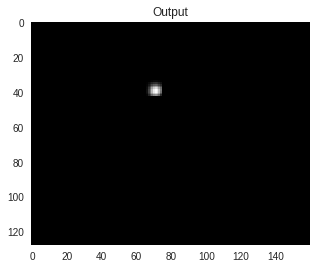


#Frame 46

#Frame 47

#Frame 48

#Frame 49

#Frame 50


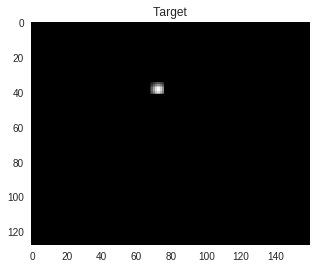

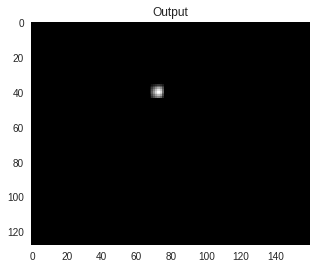


#Frame 51


In [0]:
# Testing the model
test_output, test_loss_list = sweaty_evaluator.test_model(trained_model, test_loader)

In [0]:
# Plotting Loss
#plot_loss(train_loss_list, model_path+'sweaty2_train_loss_final_1000.png')
sweaty_evaluator.plot_loss(val_loss_list, model_path+'sweaty1_val_loss.png')
sweaty_evaluator.plot_loss(test_loss_list, model_path+'sweaty1_test_loss.png')

In [0]:
test_target_list=[]
for i, batch in enumerate(test_loader):
  test_target_list.append(batch['labels'])
  
print(len(test_target_list))

val_target_list=[]
for i, batch in enumerate(val_loader):
  val_target_list.append(batch['labels'])
  
print(len(val_target_list))


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


52


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


19


In [0]:
# Find Recall, FDR & IoU for SweatyNet

sweaty_postprocess = PostProcessing()
print('-------Sweaty Validation Set-------')
#sweaty_postprocess.find_metrics(val_target_list, val_anno_path, val_output, 'sweaty')
sweaty_postprocess.find_metrics(val_output, val_anno_path)
print('\n\n-------Sweaty Test Set-------')
sweaty_postprocess.find_metrics(test_output, test_anno_path)

#sweaty_postprocess.find_metrics(test_target_list, test_anno_path, test_output, 'sweaty')

-------Sweaty Validation Set-------
false_positive 0
true_positive 19
true_negative 0
false_negative 0
Precision: 100.0 - Recall: 100.0 - FDR: 0.0 - IOU: 100.0 - Accuracy: 100.0


-------Sweaty Test Set-------
false_positive 1
true_positive 29
true_negative 22
false_negative 0
Precision: 96.7 - Recall: 100.0 - FDR: 3.3 - IOU: 96.7 - Accuracy: 98.1


# Conv LSTM

## Conv LSTM - Model



In [0]:
## https://github.com/ndrplz/ConvLSTM_pytorch

import torch.nn as nn
from torch.autograd import Variable
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        
        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding     = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias        = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)).cuda(),
                Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)).cuda())


class ConvLSTM(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim  = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        
        Parameters
        ----------
        input_tensor: todo 
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
            
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise  NotImplementedError ()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list   = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [0]:
class Convlstm_PostProcessing:

    def __init__(self):
        self.list_maximal_values_batches = []
      
    # Creating the test coordinates list of the ball 
    def get_coordinates(self, annotation_path):

        target_coordinates = []
        annotations_frame = pd.read_csv(annotation_path)

        for index, rows in annotations_frame.iterrows():
          _, _, _, x1, y1, x2, y2, _, _, _, _ = rows

          x1 = x1 / 4
          x2 = x2 / 4
          y1 = y1 / 4
          y2 = y2 / 4
          x = (x1 + x2) / 2
          y = (y1 + y2) / 2
          center = (x,y)
          target_coordinates.append(center)

        return target_coordinates
            
    def erosion(self, output_list):
        erosion_list = []
        
        kernel = np.ones((4,4),np.uint8)
        
        for i in range(0, len(output_list)):
          out = (output_list[i].reshape(1,128,160)).cpu().detach().numpy()
          
          erosion_output = cv2.erode(out, kernel, iterations = 1)
          erosion_list.append(erosion_output)
          
        return erosion_list
        
      
    
    def findmaximal(self, test_output_matrix_image, target_center_coordinates):
      z=test_output_matrix_image.permute(1,2,0)
      z=test_output_matrix_image
      z.to(dtype=t.float32)
      list_with_more_contours=[]
      internal_list_distance=[]

      center_coord_targ=target_center_coordinates
      number=np.count_nonzero(z.cpu().detach().numpy())
      if(number>0):

        prob_map=z.cpu().detach().numpy()
        prob_map = np.squeeze(prob_map)
        maximum_value=np.amax(prob_map)
        thresh=0.8*maximum_value
        bin_map = prob_map > thresh
        bin_img = img_as_ubyte(bin_map)
        _, cnts ,_= cv2.findContours(bin_img.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        s=0
        r=0
        
        cx=0.0
        cy=0.0
        #print("contours",cnts)
        for cont in cnts:
          M = cv2.moments(cont)
          if((M['m00']!=0)): 
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00']) 
          else:
            continue


          list_with_more_contours.append((cx,cy))
        
        if(len(list_with_more_contours)>1):
          #print("list_with_more_contours",list_with_more_contours)
          for k in range(0,len(list_with_more_contours)):
            dist=self.calculateDistance(list_with_more_contours[k][0],list_with_more_contours[k][1],target_center_coordinates[0],target_center_coordinates[1])
            internal_list_distance.append(dist)

          min_index=np.argmin(internal_list_distance)

          min_value=list_with_more_contours[min_index]
          self.list_maximal_values_batches.append(tuple(min_value))
          list_with_more_contours=[]
        else:
          
          if(len(list_with_more_contours)>0):  
            #print(list_with_more_contours)
            self.list_maximal_values_batches.append(list_with_more_contours[0])
            list_with_more_contours=[] 
          else:
            self.list_maximal_values_batches.append((0,0))
            

      else:
        self.list_maximal_values_batches.append((0,0))
        
      length_batch=len(self.list_maximal_values_batches)
      return self.list_maximal_values_batches[length_batch-1]


    def calculateDistance(self, x1,y1,x2,y2):
      dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
      return dist  

    def calculate_metrics(self, target_list,output_list):
      error_threshold=5
      true_positive=0
      false_positive=0
      true_negative=0
      false_negative=0
      
      #print('Target: ',target_list)
      #print('Output: ',output_list)
      
      for i in range(0,len(target_list)):
        
        #print('Target: ', target_list[i])
        #print('Output: ', output_list)
        if(target_list[i]==(0,0)):
          if output_list[i]!=(0,0):
            false_positive+=1
          else:
            true_negative+=1
        else:
          if (output_list[i]!=(0,0)):
            
            distance = self.calculateDistance(target_list[i][0],target_list[i][1],output_list[i][0],output_list[i][1])
            if (distance < error_threshold):
              true_positive+=1
            else:
              false_negative+=1
          else:
            false_negative+=1

      list_metrics=[true_positive,true_negative,false_positive,false_negative]    
      return list_metrics    

    def calculating_metrics(self, metrics_list):
      true_positive =  metrics_list[0]
      true_negative  = metrics_list[1]
      false_positive = metrics_list[2]
      false_negative = metrics_list[3]
      
      Precision=(true_positive)/(false_positive+true_positive)
      Recall=(true_positive/(true_positive+false_negative))
      IOU=(true_positive/(true_positive+false_positive+false_negative))
      FDR=(false_positive/(false_positive+true_positive))
      Accuracy=(true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)
      
      list_calculated_metrics=[Precision*100, Recall*100, FDR*100, IOU*100, Accuracy*100]
      
      return list_calculated_metrics

    def find_metrics(self, target_list, annotation_path, out_list, findmetric):
      #print('target_list',len(target_list))
      output_list=[]
      metrics_list=[]
      out_erosion_list=[]
      target_lis=[]
      target_coordinates = self.get_coordinates(annotation_path)
      #out_erosion_list_target = self.erosion(target_list)
      
      out_erosion_list_output = self.erosion(out_list)
      
      if findmetric == 'convlstm':
          for i in range(0, len(target_list)):
            #print(target_list[i].shape)
            target_lis.append(self.findmaximal((target_list[i].squeeze(0)), target_coordinates[i]))
          for i in range(0, len(out_erosion_list_output)):  
            output_list.append(self.findmaximal(t.from_numpy(out_erosion_list_output[i]), target_lis[i]))
        #print("output list length",len(target_coordinates_centers),len(output_list))    
          metrics_list = self.calculate_metrics(target_lis, output_list)  
      
      else:
          for i in range(0, len(out_erosion_list_output)):
            output_list.append(self.findmaximal(t.from_numpy(out_erosion_list_output[i]), target_coordinates[i]))
          metrics_list = self.calculate_metrics(target_coordinates, output_list)
      
      PostMetrics = self.calculating_metrics(metrics_list)
      print("Precision: {:.1f} - Recall: {:.1f} - FDR: {:.1f} - IOU: {:.1f} - Accuracy: {:.1f}"
            .format(PostMetrics[0], PostMetrics[1], PostMetrics[2], PostMetrics[3], PostMetrics[4]))


## Conv LSTM - Evaluation

In [0]:
class Convlstm_ModelEvaluator:

    def __init__(self, model_path, conv_img_path):
      self.model_path = model_path
      self.conv_img_path = conv_img_path

    def convlstm_train(self, convlstm_model, val_loader, val_output):

        convlstm_output=[]
        num_epochs = 50
        seq_len = 5

        for epoch in range(num_epochs):
            iter = 0

            for i, batch in enumerate(val_loader):

                batch_labels = batch['labels'].permute(0, 3, 1, 2).cuda().float()
                target = batch_labels
                input = val_output[i]
    
                for k in range(iter, (seq_len-1)+i):
    
                    if(i+4 <= len(val_loader.dataset)-1):
                        input = t.cat((input, val_output[k]), dim = 0)
                        target = t.cat((target, val_loader.dataset[k]['labels'].permute(2, 0, 1).unsqueeze(0).cuda().float()), dim = 0)
                    else:
                        break

    
                target = target[-1].unsqueeze(0)
                input = input.unsqueeze(0)

                convlstm_model.zero_grad()
                conv_out = convlstm_model(input.detach(), hidden_state=None)
    
                convlstm_loss = convlstm_criterion(conv_out[1][0][0], target)
    
                convlstm_loss.backward()
                convlstm_optimizer.step()

                target_img = self.conv_img_path+'convlstm\sweaty1_lab3_convtrain_target'+str(i)+'.png'
                output_img = self.conv_img_path+'convlstm\sweaty1_lab3_convtrain_output'+str(i)+'.png'
  
                if iter % 5 == 0:
                  torchvision.utils.save_image(target, target_img)
                  torchvision.utils.save_image(conv_out[1][0][0][0], output_img)

                  #Sweaty_ModelEvaluator.visualize_output((target.reshape(1,128,160)).cpu().detach().numpy(), 'Target')
                  #Sweaty_ModelEvaluator.visualize_output((conv_out[1][0][0][0]).cpu().detach().numpy(), 'Output')
                
                iter += 1  

            print('Epoch: {}/{} - Loss: {:.6f}'.format(epoch+1, num_epochs, convlstm_loss.data))
            t.save(convlstm_model.state_dict(), self.model_path+'convlstm_sweatynet1_trained_model_'+str(epoch)+'.pkl')

        return convlstm_model  


    def convlstm_test(self, convlstm_trained, test_loader, test_output):

        convlstm_output=[]
        convlstm_target=[]
        seq_len = 5

        iter = 0

        for i, batch in enumerate(test_loader):

            batch_labels = batch['labels'].permute(0, 3, 1, 2).cuda().float()
            target = batch_labels
            input = test_output[i]

            for k in range(iter, (seq_len-1)+i):
                if(i+4 <= len(test_loader.dataset)-1):
                  input = t.cat((input, test_output[k]), dim = 0)
                  target = t.cat((target, test_loader.dataset[k]['labels'].permute(2, 0, 1).unsqueeze(0).cuda().float()), dim = 0)
                else:
                  break

            target = target[-1].unsqueeze(0)
            input = input.unsqueeze(0)


            conv_out = convlstm_trained(input, hidden_state=None)
            convlstm_output.append(conv_out[1][0][0])
            convlstm_target.append(target)

            target_img = self.conv_img_path+'sweaty1_lab3_convtest_target'+str(i)+'.png'
            output_img = self.conv_img_path+'sweaty1_lab3_convtest_output'+str(i)+'.png'
            torchvision.utils.save_image(target, target_img)
            torchvision.utils.save_image(conv_out[1][0][0][0], output_img)
            #Sweaty_ModelEvaluator.visualize_output((target.reshape(1,128,160)).cpu().detach().numpy(), 'Target')
            #Sweaty_ModelEvaluator.visualize_output((conv_out[1][0][0][0]).cpu().detach().numpy(), 'Output')

            iter += 1  

        return convlstm_output, convlstm_target        



In [0]:
# Hyperparameters
learning_rate = 0.001

# Conv LSTM model object creation
height, width = 128, 160
convlstm_model = ConvLSTM(input_size=(height, width), 
                 input_dim=1,
                 hidden_dim=[32,1],
                 kernel_size=(3,3),
                 num_layers=2,
                 batch_first=True,
                 bias=False,
                 return_all_layers=False)

# Initializing the MSE Loss function
convlstm_criterion = nn.MSELoss()

# Initializing the Adam Optimitzer function
convlstm_optimizer = t.optim.Adam(convlstm_model.parameters(), lr = learning_rate)

source_path = 'gdrive/My Drive/'
model_path = source_path+'SoccerDatasetTrain/sweaty1/'
conv_img_path = source_path+'SoccerDatasetTrain/sweaty1/conv/'
convlstm_eval = Convlstm_ModelEvaluator(model_path, conv_img_path)

In [0]:
# Training the model
convlstm_trained = convlstm_eval.convlstm_train(convlstm_model, val_loader, val_output)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: U

Epoch: 1/50 - Loss: 0.005293
Epoch: 2/50 - Loss: 0.002860
Epoch: 3/50 - Loss: 0.002110
Epoch: 4/50 - Loss: 0.002037
Epoch: 5/50 - Loss: 0.002028
Epoch: 6/50 - Loss: 0.002027
Epoch: 7/50 - Loss: 0.002028
Epoch: 8/50 - Loss: 0.002030
Epoch: 9/50 - Loss: 0.002032
Epoch: 10/50 - Loss: 0.002033
Epoch: 11/50 - Loss: 0.002035
Epoch: 12/50 - Loss: 0.002036
Epoch: 13/50 - Loss: 0.002037
Epoch: 14/50 - Loss: 0.002037
Epoch: 15/50 - Loss: 0.002038
Epoch: 16/50 - Loss: 0.002039
Epoch: 17/50 - Loss: 0.002039
Epoch: 18/50 - Loss: 0.002039
Epoch: 19/50 - Loss: 0.002040
Epoch: 20/50 - Loss: 0.002040
Epoch: 21/50 - Loss: 0.002040
Epoch: 22/50 - Loss: 0.002040
Epoch: 23/50 - Loss: 0.002041
Epoch: 24/50 - Loss: 0.002041
Epoch: 25/50 - Loss: 0.002041
Epoch: 26/50 - Loss: 0.002041
Epoch: 27/50 - Loss: 0.002041
Epoch: 28/50 - Loss: 0.002041
Epoch: 29/50 - Loss: 0.002041
Epoch: 30/50 - Loss: 0.002041
Epoch: 31/50 - Loss: 0.002041
Epoch: 32/50 - Loss: 0.002041
Epoch: 33/50 - Loss: 0.002041
Epoch: 34/50 - Loss

In [0]:
convlstm_model.load_state_dict(t.load(model_path+'convlstm_sweatynet1_trained_model.pkl'))
convlstm_trained = convlstm_model

In [0]:
convlstm_output, convlstm_target = convlstm_eval.convlstm_test(convlstm_trained, test_loader, test_output)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: U

In [0]:
# Find Recall, FDR & IoU for SweatyNet + Conv LSTM

convlstm_postprocess = Convlstm_PostProcessing()
print('\n\n-------Convlstm Test Set-------')
convlstm_postprocess.find_metrics(convlstm_target, test_anno_path, convlstm_output, 'convlstm')



-------Convlstm Test Set-------
Precision: 90.6 - Recall: 100.0 - FDR: 9.4 - IOU: 90.6 - Accuracy: 94.2


# **Tasks - Completed**

1. The SweatyNet Model has been implemented and the soccer ball dataset generated from image tagger has been used. 
2. The target matrix is derived from the annotations of the images. 
3. The model is trained and tested for single images.
4. The post-processing steps for finding the RC and FDR.
5. The Convolutional LSTM layer was added and tested.
6. Final Report
---








